# DAY 11: Bayesian versus frequentist inference


### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: June 22nd, 2:00 pm Kigali Time

**First name**: _________________________________________________________


**Last name**: _____________

## Learning Goals:

1. understand the pros and cons of predictive uncertainties from bootstrapping maximum likelihood models

2. understand the pros and cons of predictive uncertainties from Bayesian models


### Load necessary libraries

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from autograd import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

**No need to read in details!**

In [ ]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
  prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
  prior_precision = np.linalg.inv(prior_variance)

  joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
  joint_variance = np.linalg.inv(joint_precision)
  joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

  #sampling 100 points from the posterior
  posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

  #take posterior predictive samples
  posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
  posterior_predictive_samples = posterior_predictions + np.random.normal(0, noise_var**0.5, size=posterior_predictions.shape)

  return posterior_predictions, posterior_predictive_samples


def generate_data(number_of_points=10, noise_variance=0.5):
  #training x
  x = np.hstack((np.linspace(-10, -5, number_of_points), np.linspace(5, 10, number_of_points)))
  #function relating x and y
  f = lambda x:  0.01 * x**3
  #y is equal to f(x) plus gaussian noise
  y = f(x) + np.random.normal(0, noise_variance**0.5, 2 * N)
  x_test = np.linspace(-11, 11, 100)
  return x, y, x_test

## Bootstrap Uncertainties for Maximum Likelihood Models for a Small Dataset

In these exercises we explore predictive uncertaintites for maximum likelihood polynomial regression models that come from bootstrapping.

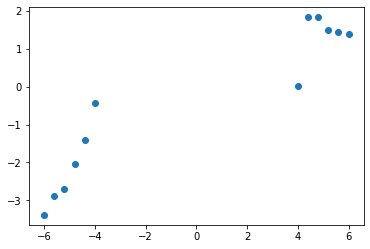

In [ ]:
# we first read in the data
data = pd.read_csv('https://raw.githubusercontent.com/onefishy/Rwanda-course-2020/master/In-class/lab_7_data.csv')

# we split the data into covariates x and labels y
x_train = data['x'].values
y_train = data['y'].values

# we create a test set
x_test = np.linspace(-8, 8, 100)

plt.scatter(x_train, y_train)

**Exercise 1:** Create 100 bootstrap training datasets from the data and fit a polynomial regression on each. Visualize these polynomials and visualize their 95% predictive interval. 

Using this visualization, summarize where the model is the most confident in its predictions and where it is least confident.

Can you explain why the model is not confident in certain places but confident in others?

In [ ]:
# Step 1: make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
poly = PolynomialFeatures(10)

# Step 2: make an instance of the LinearRegression to perform regression
linear_model = LinearRegression(fit_intercept=False)

In [ ]:
# number of boostrap polyomial models to fit
trials = 100
# make a list to record all their predictions
y_test_poly = []

# Step 3: bootstrap 100 training sets and fit a polynomial regression model on each
for i in range(trials):

    if i % 10 == 0:
        print('bootstrap:', i)
        
    # generate a bootstrap sample from the data
    indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
    bootstrap_x = x_train[indices]
    bootstrap_y = y_train[indices]
    
    # fit a polynomial model
    bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
    bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    linear_model.fit(bootstrap_x_poly, bootstrap_y)

    # predict on x_test
    y_test = linear_model.predict(bootstrap_x_test_poly)
    y_test_poly.append(y_test)

trial: 0
trial: 10
trial: 20
trial: 30
trial: 40
trial: 50
trial: 60
trial: 70
trial: 80
trial: 90


In [ ]:
y_test_poly = np.array(y_test_poly)

# Step 4: compute the 97.5 th percentile of the posterior predictive predictions
y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

# Step 5: compute the 50 th percentile of the posterior predictive predictions
y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

# Step 6: compute the 2.5 th percentile of the posterior predictive predictions
y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

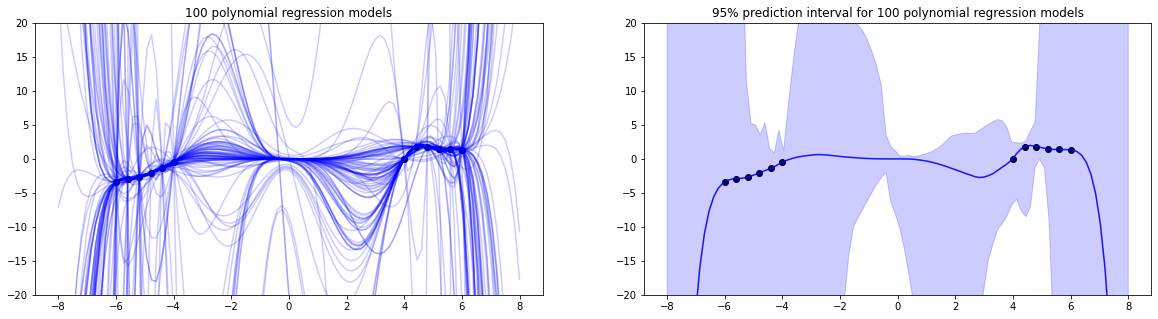

In [ ]:
# Step 7: Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(x_train, y_train, color='black', label='data')
ax[1].scatter(x_train, y_train, color='black', label='data')

# plot the 100 polynomial models
for y_poly in y_test_poly:
    ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

ax[0].set_ylim([-20, 20])
ax[0].set_title('{} polynomial regression models'.format(trials))

# plot 95% predictive interval
ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

ax[1].set_ylim([-20, 20])
ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

plt.show()

## Bayesian Posterior Predictive Uncertainties for a Small Data set

In these exercises we explore posterior predictive uncertaintites from a Bayesian model.

**Exercise 2:** Fit a Bayesian polynomial regression model to the same dataset. Visualize the posterior predictive.

Compare the 95% posterior predictive interval of the Bayesian polynomial models to that of the bootstrap polynomial models. Describe the difference between these two predictive intervals. Based on lectures, why do you think these predictive intervals are different. ***Hint:*** think about what extra information is contained in a Bayesian model.

Based on your description, which model should we choose if we want to use the prediction uncertainties to decide whether or not we should trust the model for a real life task?

In [ ]:
# Step 1: fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

In [ ]:
# Step 2: define noise level in the data
noise_variance = 0.5

# Step 2: define the variance of the prior distribution
prior_variance = 1.

# Step 3: define the number of samples to take from the posterior
samples = 100

# Step 4: get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)

In [ ]:
# Step 5: compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Step 6: compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Step 7: compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

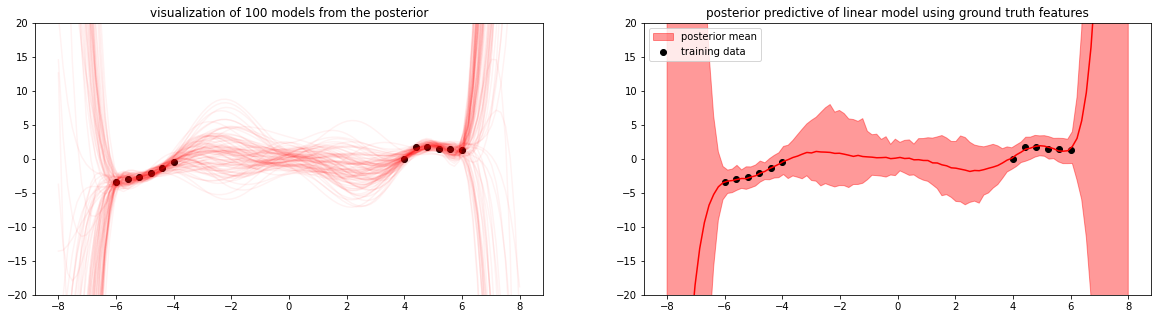

In [ ]:
# Step 8: Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# visualize the training data 
ax[0].scatter(x_train, y_train, color='black', label='training data') 

# visualize each model from the posterior
for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05)

ax[0].set_ylim([-20, 20])
ax[0].set_title('visualization of {} models from the posterior'.format(samples))

# visualize the mean of the posterior predictive
ax[1].plot(x_test, pp_mean, color='red')
# visualize the 95% posterior predictive interval
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean')
# visualize the training data
ax[1].scatter(x_train, y_train, color='black', label='training data')

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of linear model using ground truth features')
ax[1].set_ylim([-20, 20])
plt.show()

## Bootstrap Uncertainties for Maximum Likelihood Models for a Large Dataset

In these exercises we explore predictive uncertaintites for maximum likelihood polynomial regression models that comes from bootstrapping a **large** dataset.

In [ ]:
# number of data points in each of the two segments of the domain
N = 200
# noise level in the data
noise_variance = 1.

# generate toy data
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)

**Exercise 3:** Create 100 bootstrap training datasets from the data and fit a polynomial regression on each. Visualize these polynomials and visualize their 95% predictive interval. 

Compare this to the 95% predictive interval in Exercise 1. What is the difference between these two intervals. Can you explain why these two intervals are different. ***Hint:*** think about the effect of the number of data points on complex functions in terms of overfitting and high variance.

In [ ]:
# Step 1: make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
poly = PolynomialFeatures(10)

# Step 2: make an instance of the LinearRegression to perform regression
linear_model = LinearRegression(fit_intercept=False)

In [ ]:
# number of boostrap polyomial models to fit
trials = 100
# make a list to record all their predictions
y_test_poly = []

# Step 3: bootstrap 100 training sets and fit a polynomial regression model on each
for i in range(trials):

    if i % 10 == 0:
        print('bootstrap:', i)
        
    # generate a bootstrap sample from the data
    indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
    bootstrap_x = x_train[indices]
    bootstrap_y = y_train[indices]
    
    # fit a polynomial model
    bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
    bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    linear_model.fit(bootstrap_x_poly, bootstrap_y)

    # predict on x_test
    y_test = linear_model.predict(x_test_poly)
    y_test_poly.append(y_test)

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


In [ ]:
y_test_poly = np.array(y_test_poly)

# Step 4: compute the 97.5 th percentile of the posterior predictive predictions
y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

# Step 5: compute the 50 th percentile of the posterior predictive predictions
y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

# Step 6: compute the 2.5 th percentile of the posterior predictive predictions
y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

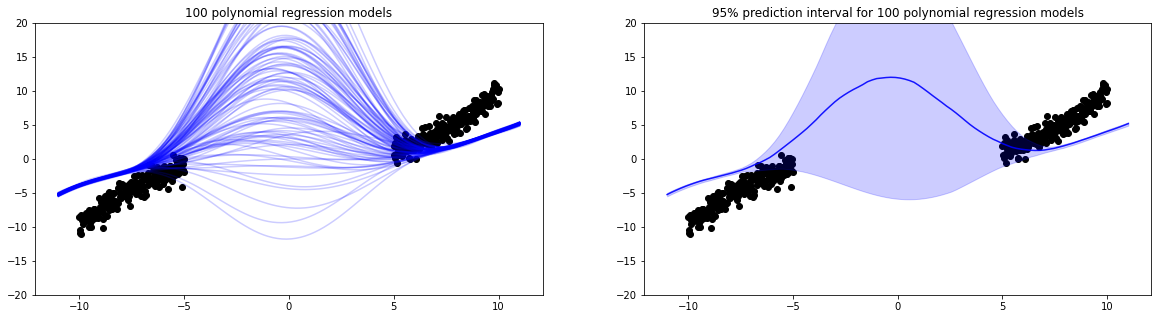

In [ ]:
# Step 7: Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(x_train, y_train, color='black', label='data')
ax[1].scatter(x_train, y_train, color='black', label='data')

# plot the 100 polynomial models
for y_poly in y_test_poly:
    ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

ax[0].set_ylim([-20, 20])
ax[0].set_title('{} polynomial regression models'.format(trials))

# plot 95% predictive interval
ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

ax[1].set_ylim([-20, 20])
ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

plt.show()

## Bayesian Posterior Predictive Uncertainties for a Large Data set

In these exercises we explore posterior precitive uncertaintites from a Bayesian model on a large data set.

**Exercise 4:** Fit a Bayesian polynomial regression model the same dataset. Visualize the posterior predictive.

Compare the 95% posterior predictive interval of the Baysian to that of the bootstrap polynomial models. Describe the difference between these two prective intervals. Based on lectures, why do you think these prective intervals are different. ***Hint:*** think about what extra information is contained in a Bayesian model.

Change the prior variance to 50. Now, compare the 95% posterior predictive interval of the Baysian to that of the bootstrap polynomial models. Describe the difference between these two prective intervals. 

Based on your description, which model should we choose if we want to use the prediction uncertainties to decide whether or not we should trust the model for a real life task?

In [ ]:
# Step 1: fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

In [ ]:
# Step 2: define the variance of the prior distribution
prior_variance = 1.

# Step 3: define the number of samples to take from the posterior
samples = 100

# Step 4: get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)

In [ ]:
# Step 5: compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Step 6: compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Step 7: compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

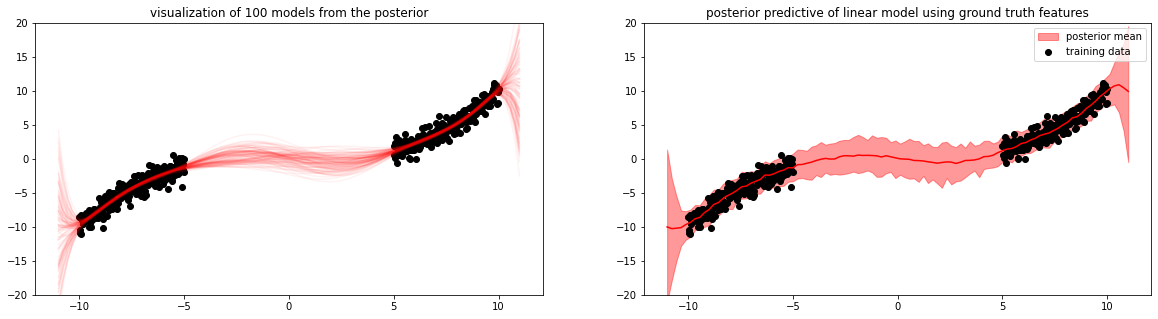

In [ ]:
# Step 8: Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# visualize the training data 
ax[0].scatter(x_train, y_train, color='black', label='training data') 

# visualize each model from the posterior
for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05)

ax[0].set_ylim([-20, 20])
ax[0].set_title('visualization of {} models from the posterior'.format(samples))

# visualize the mean of the posterior predictive
ax[1].plot(x_test, pp_mean, color='red')
# visualize the 95% posterior predictive interval
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean')
# visualize the training data
ax[1].scatter(x_train, y_train, color='black', label='training data')

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of linear model using ground truth features')
ax[1].set_ylim([-20, 20])
plt.show()